In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def disp_dataset(ds, limit=None, print_elements=True):
    count = 0

    for x in ds:
        count += 1
        if print_elements:
            print(x)
        if limit is not None and count >= limit:
            break
    print(f"Count:{count}")


In [9]:
data = keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = data
X_train = X_train / 255
X_test = X_test / 255
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def prepare_dataset(X_train, y_train):
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_set = train_set.map(lambda x,y: (tf.cast(x, ), y))
    train_set = train_set.map(lambda x,y: (tf.reshape(x, x.shape + (1,)),y))
    train_set = train_set.batch(32).prefetch(1)
    return train_set

def show_image(images):
    for img in images:
        plt.figure()
        plt.imshow(img)


train_set = prepare_dataset(X_train, y_train)
val_set = prepare_dataset(X_val, y_val)

image shape:(28, 28)
image size:28
channel size:1


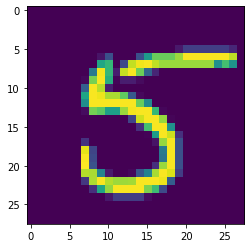

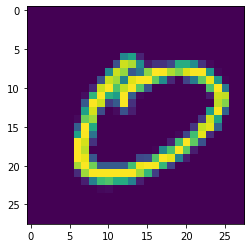

In [3]:
batch_size = 32
codings_size = 30
img_shape = X_train[0].shape
img_size = img_shape[0]
channel_size = 1 if len(img_shape) < 3 else img_shape[-1]
n_classes = 10

print(f"image shape:{img_shape}")
print(f"image size:{img_size}")
print(f"channel size:{channel_size}")

show_image(X_train[:2])

In [36]:

def test_discriminator(gan, test_size=100, reshape=False):
    generator, discriminator = gan.layers
    unit_size = int(test_size / 2)
    noise = tf.random.normal(shape=[unit_size, codings_size])
    X_fake = generator(noise)


    X_reel = tf.constant(X_test[:unit_size, :, :])
    if reshape:
        X_fake = tf.reshape(X_fake, X_fake.shape + (1,))
        X_reel = tf.reshape(X_reel, X_reel.shape + (1,))

    y_fake = tf.constant([[0.]] * unit_size)
    y_reel = tf.constant([[1.]] * unit_size)

    predict_fake = tf.math.round(discriminator(X_fake))
    predict_reel = tf.math.round(discriminator(X_reel))

    acc_fake = accuracy_score(y_fake, predict_fake)
    acc_reel = accuracy_score(y_reel, predict_reel)

    print(f"acc_fake:{acc_fake}")
    print(f"acc_reel:{acc_reel}")

def gen_images(model, labels = None, codings_size=32, n=5, reshape=False):
    noises = tf.random.normal([n, codings_size])
    labels_asked = np.random.randint(0, n_classes, n) if not labels else labels
    generated = model([noises, labels_asked])
    if reshape:
        generated = tf.reshape(generated, generated.shape[:-1])
    generated = generated.numpy()
    show_image(generated)

import time

def train_cgan(gan, dataset, batch_size, codings_size, n_epochs=50, gen=None, disc=None):
    generator, discriminator = gan.layers if gen is None else (gen, disc)
    for epoch in range(n_epochs):
        losses_disc = []
        losses_gen = []
        accuracies_disc = []
        accuracies_gen = []
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        start = time.time()
        for X_batch in dataset: # On suppose X_batch de dimension 2: ayant l'image, et le label

            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            labels_asked = np.random.randint(0, n_classes, batch_size) 
            generated_images = generator([noise, labels_asked])

            X_fake_and_real = tf.concat([generated_images, X_batch[0]], axis=0)
            labels_fake_and_real = tf.concat([labels_asked, X_batch[1]] ,axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            loss, acc = discriminator.train_on_batch([X_fake_and_real, labels_fake_and_real], y1)
            losses_disc.append(loss)
            accuracies_disc.append(acc)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            labels_asked = np.random.randint(0, n_classes, batch_size)

            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            loss, acc = gan.train_on_batch([noise, labels_asked], y2)
            losses_gen.append(loss)
            accuracies_gen.append(acc)

        end = time.time()
        print(f"Epoch took {(end - start)}. s")
        print(f"Discriminator loss:{np.mean(losses_disc)} | accuracy: {np.mean(accuracies_disc)}")
        print(f"Generator loss:{np.mean(losses_gen)} | accuracy: {np.mean(accuracies_gen)}")

def train_gan_replay(gan, dataset, batch_size, codings_size, batch_memory = 5, n_epochs=50, generator_=None, discriminator_=None):
    generator, discriminator = gan.layers if generator_ is None else (generator_, discriminator_)
    memory = [] # en initialisant ici, la mémoire se porte sur toutes les itérations aussi

    def add_to_memory(memory, batch):
        if len(memory) > 5:
            memory = memory[1:]
        memory.append(batch)

    for epoch in range(n_epochs):
        losses_disc = []
        losses_gen = []
        accuracies_disc = []
        accuracies_gen = []
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        start = time.time()
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)

            X_fake_and_real = [generated_images, X_batch]
            X_fake_and_real = X_fake_and_real + memory
            X_fake_and_real = tf.concat(X_fake_and_real, axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size + [[0.]] * len(memory) * batch_size)

            discriminator.trainable = True
            loss, acc = discriminator.train_on_batch(X_fake_and_real, y1)
            losses_disc.append(loss)
            accuracies_disc.append(acc)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            loss, acc = gan.train_on_batch(noise, y2)
            losses_gen.append(loss)
            accuracies_gen.append(acc)

            add_to_memory(memory, generated_images)

        end = time.time()
        print(f"Epoch took {(end - start)}. s")
        print(f"Discriminator loss:{np.mean(losses_disc)} | accuracy: {np.mean(accuracies_disc)}")
        print(f"Generator loss:{np.mean(losses_gen)} | accuracy: {np.mean(accuracies_gen)}")


In [30]:
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2D, LeakyReLU, Dropout, Flatten, Conv2DTranspose
from tensorflow.keras.models import Model

def create_discriminator(n_classes = 10):
    # label input
    # embedding for categorical input
    # scale up to image dimensions with linear activation
    # reshape to additional channel
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(channel_size * img_size ** 2 )(li)
    li = Reshape([img_size, img_size, channel_size])(li)

    # image input
    in_image = Input(shape=[img_size, img_size, channel_size])
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    discriminator = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                            activation=keras.layers.LeakyReLU(0.2),
                            input_shape=[img_size, img_size, channel_size + 1]), # channel_size +1 car on rajoute une carte de caractéristique, celle ayant l'information du label
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                            activation=keras.layers.LeakyReLU(0.2)),
        keras.layers.Dropout(0.4),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    outputs = discriminator(merge)
    model = Model([in_image, in_label], outputs)

    # compile model
	# opt = Adam(lr=0.0002, beta_1=0.5)
	# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def create_generator(codings_size = 30, n_classes = 10):
	# label input
	# embedding for categorical input
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(7 * 7 * channel_size)(li)
    li = Reshape((7, 7, channel_size))(li)

    # image generator input
    in_lat = Input(shape=[codings_size])
    gen = Dense(128 * 7 * 7)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    gen = keras.layers.BatchNormalization()(gen)

    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 28x28
    out_layer = Conv2DTranspose(channel_size, (5,5), strides=2, activation='sigmoid', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)

	# # merge image gen and label input
	# merge = Concatenate()([gen, li])
	# # upsample to 14x14
	# gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	# gen = LeakyReLU(alpha=0.2)(gen)
	# # upsample to 28x28
	# gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	# gen = LeakyReLU(alpha=0.2)(gen)
	# # output
	# out_layer = Conv2D(1, (7,7), activation='sigmoid', padding='same')(gen)
	# # define model
	# model = Model([in_lat, in_label], out_layer)
    return model

def create_cgan(codings_size = 30, n_classes = 10):
    # # On reprend le modèle DCGAN du livre
    # generator = keras.models.Sequential([
    #     keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    #     keras.layers.Reshape([7, 7, 128]),
    #     keras.layers.BatchNormalization(),
    #     keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
    #                                 activation="selu"),
    #     keras.layers.BatchNormalization(),
    #     keras.layers.Conv2DTranspose(channel_size, kernel_size=5, strides=2, padding="SAME",
    #                                 activation="sigmoid"),
    # ])
    # discriminator = keras.models.Sequential([
    #     keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
    #                         activation=keras.layers.LeakyReLU(0.2),
    #                         input_shape=[img_size, img_size, 3]),
    #     keras.layers.Dropout(0.4),
    #     keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
    #                         activation=keras.layers.LeakyReLU(0.2)),
    #     keras.layers.Dropout(0.4),
    #     keras.layers.Flatten(),
    #     keras.layers.Dense(1, activation="sigmoid")
    # ])

    generator = create_generator(codings_size = codings_size, n_classes=n_classes)
    discriminator = create_discriminator(n_classes=n_classes)

    generator_input, generator_label = generator.input
    generated_image = generator.output
    discriminator_output = discriminator([generated_image, generator_label])
    gan = keras.models.Model(generator.input, discriminator_output)

    optimizer = keras.optimizers.Nadam(lr=1e-3)
    discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    discriminator.trainable = False
    gan.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return gan, generator, discriminator

cgan, generator, discriminator = create_cgan()


In [33]:
train_cgan(cgan, train_set, batch_size, codings_size, n_epochs=20, gen=generator, disc=discriminator)
gen_images(generator, codings_size = codings_size, n = 10)
# show_image(pokemon_list[:2])

Epoch 1/20
Epoch took 38.98533034324646. s
Discriminator loss:0.5491757200956344 | accuracy: 0.7191875
Generator loss:1.3692016491095225 | accuracy: 0.24097916666666666
Epoch 2/20
Epoch took 39.33521866798401. s
Discriminator loss:0.5710446918209394 | accuracy: 0.7013333333333334
Generator loss:1.2503376319011053 | accuracy: 0.2542291666666667
Epoch 3/20
Epoch took 39.39690685272217. s
Discriminator loss:0.5809705914457639 | accuracy: 0.6956979166666667
Generator loss:1.2197455173333487 | accuracy: 0.2560625
Epoch 4/20
Epoch took 39.55102467536926. s
Discriminator loss:0.5800444837411245 | accuracy: 0.69478125
Generator loss:1.2167186379035313 | accuracy: 0.26127083333333334
Epoch 5/20
Epoch took 39.730796813964844. s
Discriminator loss:0.5852421746651332 | accuracy: 0.6892916666666666
Generator loss:1.184251305381457 | accuracy: 0.2649166666666667
Epoch 6/20
Epoch took 39.93453407287598. s
Discriminator loss:0.5887155365943909 | accuracy: 0.6857291666666666
Generator loss:1.1720451494

ValueError: Layer model_6 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor: shape=(10, 30), dtype=float32, numpy=
array([[-1.45685983e+00, -1.30020201e+00,  2.11911127e-01,
        -7.13725090e-01,  1.14820969e+00,  6.18646860e-01,
         5.37816584e-01, -8.66573989e-01,  9.09324408e-01,
        -1.14903259e+00, -8.17136168e-01,  7.73738444e-01,
        -1.36404410e-02,  2.01763764e-01,  1.99521625e+00,
        -1.61358304e-02, -3.48228693e-01,  4.43460159e-02,
         2.44591877e-01,  2.05231443e-01, -9.49031115e-01,
        -2.64220059e-01, -8.28134954e-01, -3.50444645e-01,
         1.22175109e+00, -1.45518422e-01,  6.22896969e-01,
        -1.77418232e-01, -2.47541165e+00,  4.81512755e-01],
       [-3.65744501e-01,  1.12897456e-02,  1.71179056e+00,
        -9.85011756e-01, -3.73798549e-01, -5.62386036e-01,
        -1.42599571e+00, -1.94536909e-01, -1.12893116e+00,
         1.57552406e-01, -8.15063238e-01,  1.84107482e+00,
        -1.86989045e+00, -1.69063568e-01,  9.53205049e-01,
         2.24402523e+00, -9.22545075e-01, -5.44706345e-01,
        -2.89368451e-01, -3.60713601e-01, -6.00367248e-01,
         1.41702771e-01,  9.08043444e-01,  2.35782623e+00,
         9.57252324e-01, -6.81756854e-01,  3.15616399e-01,
         1.05167523e-01,  8.95090640e-01, -8.91674533e-02],
       [-6.04985476e-01, -9.55058575e-01,  1.42451692e+00,
         6.30644619e-01, -8.27960253e-01,  1.16367149e+00,
         6.59736335e-01,  1.64700294e+00,  7.54752085e-02,
        -4.40938681e-01, -3.10890734e-01,  1.89024508e-01,
         2.87601084e-01, -1.15104258e+00, -9.88958657e-01,
         9.84958172e-01,  3.39925796e-01, -1.39090872e+00,
        -2.10206556e+00, -6.16087556e-01,  1.55325711e-01,
         1.19782066e+00, -7.12819278e-01,  4.05695915e-01,
         2.90382862e-01,  1.60400844e+00, -6.87615573e-02,
        -5.24447262e-01, -3.07394505e-01,  1.99284256e+00],
       [ 1.11524177e+00,  5.87990470e-02,  2.40508035e-01,
         2.15450197e-01,  2.31083557e-01, -1.41468847e+00,
        -2.19308153e-01,  1.21839297e+00,  1.76956880e+00,
         2.76746862e-02, -7.32586861e-01,  9.26628828e-01,
        -4.56947871e-02,  1.84651339e+00, -8.05726886e-01,
         2.69804448e-01,  5.69867611e-01, -3.29177409e-01,
        -7.83938169e-01,  1.73098683e-01,  4.15223390e-02,
        -7.57487237e-01, -1.12523317e-01,  1.15618265e+00,
         4.81547505e-01, -1.39236391e+00,  9.59404528e-01,
        -4.96369272e-01, -4.21077222e-01,  1.06050774e-01],
       [ 1.96973801e-01,  1.51600122e-01, -6.78662479e-01,
         3.66354585e-01, -2.15705442e+00,  1.14183486e+00,
         3.31633180e-01, -2.17676902e+00, -1.64941996e-01,
         6.61804736e-01, -3.74167860e-01, -1.45456648e+00,
        -1.17681193e+00,  1.28704071e+00,  9.93260816e-02,
        -3.93685937e-01, -1.17348516e+00, -2.27622002e-01,
        -8.96403551e-01,  1.15123534e+00,  2.59564817e-01,
         9.11530375e-01,  5.99668741e-01,  5.52318811e-01,
         2.57819563e-01,  5.63546658e-01,  1.35806072e+00,
        -2.97656208e-01,  1.27572036e+00, -9.18755293e-01],
       [-4.28386450e-01,  6.18926026e-02,  5.40984690e-01,
         2.79273462e+00,  6.74599826e-01,  1.28108513e+00,
         3.99021089e-01, -4.75250274e-01,  5.38829304e-02,
         1.37036037e+00,  4.69964057e-01,  3.03268164e-01,
        -6.64528787e-01,  1.67530799e+00, -1.85012728e-01,
        -3.22074354e-01, -1.28161955e+00, -3.99957374e-02,
         1.41224599e+00,  2.27571988e+00, -1.02814841e+00,
         5.46557486e-01,  1.70711324e-01, -2.00314194e-01,
         4.39763755e-01, -1.45834136e+00,  1.36790133e+00,
        -1.78172591e-03,  5.51100135e-01, -1.64675355e-01],
       [ 3.89616907e-01, -3.44149143e-01,  9.16811824e-02,
        -9.86724615e-01,  1.96323454e-01,  1.85647082e+00,
        -1.69731185e-01, -8.37521911e-01, -7.28203475e-01,
         8.59034538e-01, -1.33134186e-01, -1.69527590e+00,
        -7.14641273e-01, -9.99571204e-01, -3.79673034e-01,
        -3.43475372e-01,  4.21542913e-01, -3.22318375e-01,
         5.52140892e-01, -1.76956475e-01,  1.72471210e-01,
         1.10324347e+00, -1.32806432e+00,  1.81849909e+00,
         6.09578311e-01,  1.04552412e+00,  3.22759785e-02,
        -1.04239769e-01,  1.53485668e+00,  1.69497347e+00],
       [ 1.08531439e+00, -1.73874766e-01,  8.95284593e-01,
         7.07371473e-01,  5.10137856e-01, -5.41874580e-02,
        -1.34762093e-01, -9.42407072e-01,  1.16768515e+00,
        -7.62597471e-02,  1.29472747e-01,  1.32692719e+00,
         1.86234593e+00, -4.30529535e-01,  4.54329193e-01,
        -3.13102186e-01, -1.10474658e+00,  1.38231456e+00,
         2.63706326e-01,  1.12995148e+00,  6.78186953e-01,
        -2.66508281e-01,  2.26397827e-01,  7.55999804e-01,
         2.53015459e-01,  6.53316528e-02,  7.16135323e-01,
        -1.15010822e+00,  3.08186859e-02, -1.48583031e+00],
       [-1.95264292e+00, -7.08171010e-01, -8.07962477e-01,
         1.69753659e+00,  9.91646707e-01,  5.45391083e-01,
        -1.07166624e+00,  5.27914405e-01, -3.42152357e-01,
        -3.47693592e-01, -9.38272476e-01,  9.88499105e-01,
        -6.72039568e-01,  8.22340846e-01,  9.62561309e-01,
         1.54026616e+00, -7.10130095e-01,  7.42844701e-01,
        -1.58443081e+00, -1.27474427e+00, -4.94938791e-02,
        -4.38624807e-02, -1.56401515e+00, -1.00123537e+00,
         1.84967840e+00, -1.63116705e+00,  5.43464780e-01,
        -1.47731304e+00,  2.68192384e-02,  1.65112078e+00],
       [-1.56776619e+00,  5.30728459e-01, -1.47526115e-01,
         1.11717963e+00, -2.66674578e-01,  1.38207018e-01,
         2.48757765e-01,  7.93233931e-01, -1.15820396e+00,
         6.55232072e-01,  1.62095869e+00,  1.22878924e-01,
         1.71031916e+00, -6.00106657e-01, -2.32555941e-01,
         2.46263218e+00,  1.48004425e+00,  1.28096616e+00,
         7.80711591e-01,  7.87839592e-01,  4.37750787e-01,
        -5.26550770e-01,  2.29893878e-01, -1.49922121e+00,
        -7.59506881e-01, -7.20446408e-01, -1.04068923e+00,
         5.32187700e-01, -1.25185442e+00, -1.91870332e+00]], dtype=float32)>]

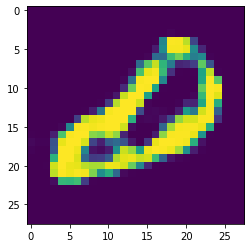

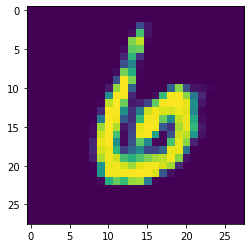

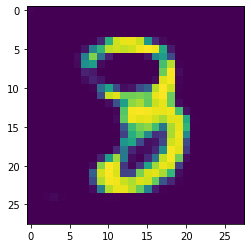

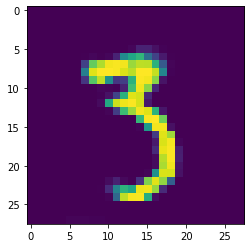

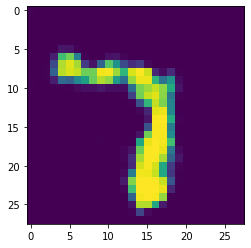

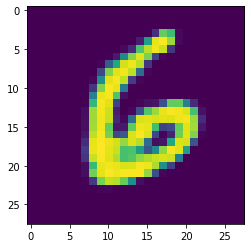

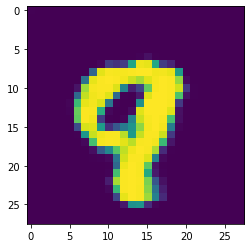

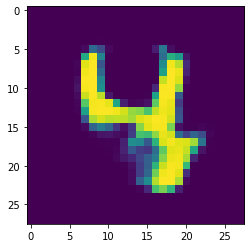

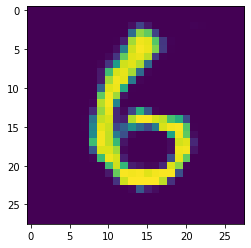

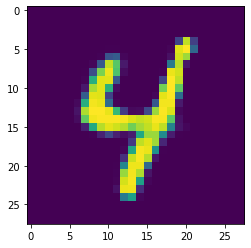

In [38]:
gen_images(generator, codings_size = codings_size, n = 10, reshape=True)
